In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re
import seaborn as sns

from PIL import Image
import chess
import chess.pgn
from io import StringIO
import os
from skimage.io import imread

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity

from collections import defaultdict
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Title:
EDA and Comparative Analysis of Chess Data 

### Abstract 
The goal of this project is to explore three datasets of chess games obtained from different sources and with different average levels of play. We will seek to answer a number of questions looking for tendencies across the different datasets. The list of questions can be found in the section "Main Questions this project seeks to answer". The acquisition, transformation and cleaning of the raw data is done and described in a separate notebook called "data_acquisition_and_cleaning".

### Introduction

#### The Game of Chess

##### Simple Rules

Chess is a board strategy game which has both ancient history and modern appeal. It is played on an 8X8 board, where each player controls 16 pieces: one king, one queen, two rooks, two knights, two bishops and eight pawns. The objective of the game is to checkmate the opponent's king, meaning the king is placed under attack with no legal moves available to escape. The game begins with white making the first move, and players alternate turns. Each piece has its own unique movement rule: pawns move forward, but capture diagonally, rooks move in straight lines, knights in an "L" shape, bishops diagonally, the queen in any direction, and the king can move one square in any direction.

##### Staggering Complexity

In his 1950 paper ""Programming a Computer for Playing Chess" the American mathematician Claude Shannon estimated the possible chess games to be $10^{120}$, a figure so vast that it dwarfs estimates for the number of atoms in the observable universe. Despite this astronomical number, experienced players often rely on recognizable patterns, developed through years of study and practice, to guide their intuition during a game. This combination of vast complexity and emergent patterns underscores the depth of information contained in every chess game, making it a fertile ground for data science and AI exploration.

##### Appeal for Computer Science and Artificial Inteligence

Chess gained significant relevance in the fields  of computer science and artificial inteligence in the mid-20th century when it became one of the first arenas for testing the capabilities of computers against human intellect. Notably, the famous match between IBM's Deep Blue and World Chess Champion Garry Kasparov in 1997 marked a pivotal moment, showcasing the potential of AI as Deep Blue became the first computer to defeat a reigning world champion in a match. Since then, chess has continued to serve as a benchmark for AI development, evolving from simple rule-based algorithms to sophisticated neural networks like AlphaZero, which have redefined our understanding of machine learning and artificial intelligence.

##### Why Chess

We have already discussed the depth of chess and its appeal to computer science. Furthermore, a lot of information can be extracted from a chess game and the metadata that comes with it. Additinally the amount of available data is huge, every day millions of games of chess are played on online servers. For example, the Chess.com server reported 37.67 million games per day played in February, 2023.
But aside from these considerations what really inspired me to work on this project is this plot(or one very similar to it for a different time period):![](rating_plot.PNG) Plot of weekly blitz distribution for  the lichess.org chess server source: the lichess.org team

I could plot this myself, the code I have in the data_acquisition_and_cleaning notebook would work fine, but I would have to download and process some large files which would require quite a bit of time and storage space, so I decided to use this plot. 
There are some interesting peaks in this plot at multiples of a hundred rating points. A hypothesis to explain this could be that humans like round numbers, set rating goals in round numbers and stop playing once they achieve them to protect their rating. What is even more interesting is the fact that the strength of this trend is not universal: at lower levels it is virtually non-existent, it emerges at ratings of middle values and gains strength until it slows down at very high ratings. This means:
* weaker players are not very interested in their ratings, they just play the game;
* a rating obsession emerges amongst players in the middle of the pack in terms of strength and starts growing;
* the peaks are skewed right, even experienced players focus on their rating;
* the tendency to sit on one's rating is less pronounced in very strong players, but it does not disappear completely(there is a small peak at 2600). The original picture I saw was of an earlier week even had peaks at 2700 and 2800. Maybe, more higher rated players were active during that week.

For me, all this meant that a  fascinating bit of knowledge of human nature can be glimpsed through the exploration of data related to chess games. It is my hope that this project will provide all kinds of different little insights of the game and possibly the players. Also being an avid chess player myself I have a bit of domain knowledge, which I hope will be helpful in this project.

#### Metadata

##### Dataset Description

Description of the three datasets used in this project:
* The first dataset called lichess_data contains 204 507 games played mostly by human players on the lichess.org chess server. All the games were played during May, 2024. The dataset has not been specifically filtered in terms of player strength or rating. The level of play of opponents should vary quite a bit: from beginner and novice players, to experienced players, to very strong world-class players.
* The second dataset called chesscom_data contains 135 098 games played only by human players on the chess.com chess server during 2024. The games in this dataset are only from the strongest blitz tournament available on this server - "Titled Tuesday". Only players possessing fide titles are eligible for entry. Consequently, the average level of play is expected to be much higher than that of lichess dataset. This dataset includes games played by many of the words elite including the highest rated player in the world - Magnus Calsen.
* The third dateset called engine_data includes 48162 games played by chess engines in the 26th season of Top Chess Engine Championship (TCEC) often regarded as the Unofficial World Computer Chess Championship because of its strong participant line-up and long time-control matches on high-end hardware, giving rise to very high-class chess.

The overall level of play in the games is expected to increase from the lichess dataset, through the chesscom dataset to the engine dataset.

##### Feature description

**date**:  
The date on which the game was played.

**white**:  
Name of the player playing with the white pieces.

**black**:  
Name of the player playing with the black pieces.

**result**:  
Outcome of the game ("1-0" for white win, "0-1" for black win, and "1/2-1/2" for draw).

**result_num**:  
Outcome of the game represented by an integer (1 for white win, -1 for black win, and 0 for draw).

**white_elo**:  
Rating of the white player on the corresponding server.

**black_elo**:  
Rating of the black player on the corresponding server.

**rating_difference**:  
"white_elo" - "black_elo", negative values indicate black has a higher rating.

**moves**:  
The moves of the game in standard chess notation.

**number_of_moves**:  
The number of moves made or length of the game.

**eco**:  
Value for Encyclopedia of Chess Openings, which provides the most common system for categorizing all chess openings.

**opening**:  
The name of the opening played in the game.

**time_control**:  
The time control used for the game.

**termination**:  
The manner in which the game ended.


### Main Questions this project seeks to answer:

* Is the player playing with the white pieces or the player playing with the black pieces favored to win, or is a draw the most likely outcome of the game?
* How common are upsets in chess? Are upsets with a higher gap in rating between the opponents correspondingly rarer?
* What are the "hot" and "cold" spots on the chess board for different pieces(squares on which the piece is placed often or rarely)?
* Is it important to control and fight for the center of the board in a chess game. Is there a relation between having more center control and winning the game?
* How does the similarity between board states in different games evolve through the course of a long game?

The main idea of this project is to contrast and compare trends or lack of such across the three datasets with different level of play.

In [3]:
# load datasets
lichess_data = pd.read_csv("clean_data/lichess_data.csv")

In [4]:
chesscom_data = pd.read_csv("clean_data/chesscom_data.csv")

In [5]:
engine_data = pd.read_csv("clean_data/engine_data.csv")

### Exploration and Analysis

#### Is the game fair, or does any of the two sides have a built in advantage?

Let us explore how often the game ends with a white win, black win and draw across the three datasets. Below we will define a function to plot the results.

In [6]:
def plot_game_outcome(dataset, dataset_name):
    number_of_games = len(dataset)
    white_wins_count = len(dataset[dataset["result_num"] == 1])
    black_wins_count = len(dataset[dataset["result_num"] == -1]) 
    draws_count = len(dataset[dataset["result_num"] == 0])
    white_wins_percentage = (white_wins_count / number_of_games) * 100
    black_wins_percentage  = (black_wins_count / number_of_games) * 100
    draws_percentage = (draws_count / number_of_games) * 100
    outcomes = {
        "white_wins": white_wins_percentage,
        "black_wins": black_wins_percentage,
        "draws": draws_percentage
    }
    plt.bar(outcomes.keys(), outcomes.values())
    plt.ylabel("Percentage")
    plt.xlabel("Game Result")
    plt.title(f'Game Outcomes for {dataset_name}')
    plt.show()


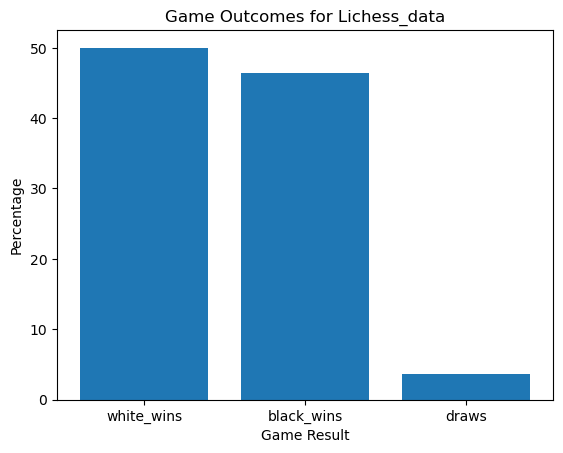

In [7]:
plot_game_outcome(lichess_data,"Lichess_data")

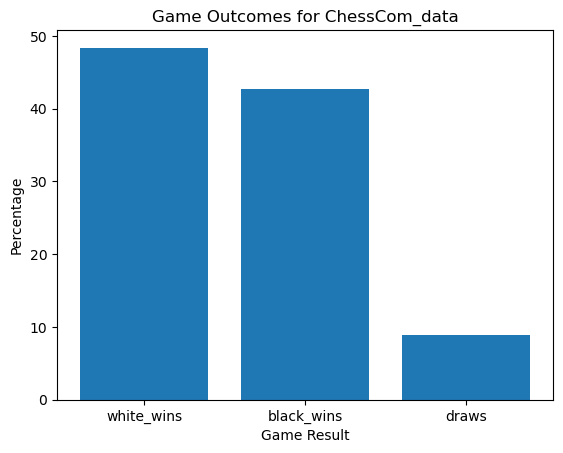

In [8]:
plot_game_outcome(chesscom_data,"ChessCom_data")

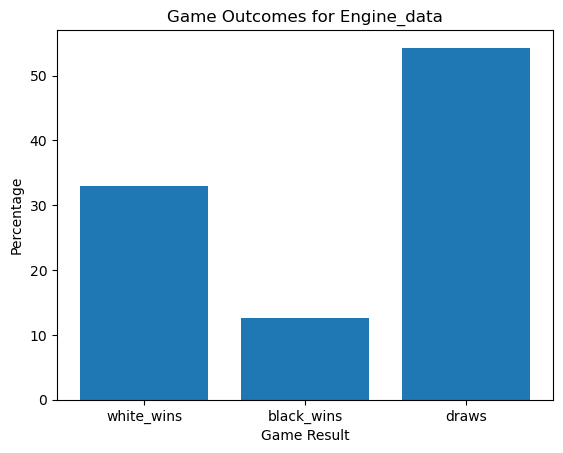

In [9]:
plot_game_outcome(engine_data,"Engine_data")

White wins more often across all the datasets. In games played by humans(Lichess and ChessCom games), though the difference between the percentage of white and black wins is not very large, while in engine games white wins more than twice as often as black! It seems that the white player enjoys the advantage in a chess game and this advantage becomes more pronounced with the increase in level of play.
At the same time, in human games draws are much rarer compared to decisive games, but show a clear increase in frequency with higher level of play. In engine games the percentage of draws is much higher, with a draw being the most likely outcome of a game by quite a bit.
Overall, with higher level of play one could expect much more draws and more white wins. 

##### Percentage of Decisive Games

Now, lets look at white and black win in the aggregate, to look for a tendency for the number of decisive games.

In [10]:
def get_decisive_games_percentage(dataset):
    total_games = len(dataset)
    decisive_games = len(dataset[(dataset["result_num"]== 1) | (dataset["result_num"]== -1)])
    percentage_decisive = (decisive_games / total_games) * 100
    return percentage_decisive

In [11]:
decisive_games_lichess = get_decisive_games_percentage(lichess_data)
decisive_games_lichess

96.36687252759074

In [12]:
decisive_games_chesscom = get_decisive_games_percentage(chesscom_data)
decisive_games_chesscom

91.11903951205791

In [13]:
decisive_games_engine = get_decisive_games_percentage(engine_data)
decisive_games_engine

45.66878451891533

The overall percentage of decisive games played by humans drops slightly(by about five percent) with higher overall level of play. The number of decisive games in engine battles is drastically smaller.

##### Rating distributions

So far we have talked about level of play somewhat abstractly, now we will look at rating distributions across the different datasets to get a better idea of the strength of players. It is important to note that the ratings in the three dateset cannot be compared if we are strict about our analysis. They come from different playing servers with probably slightly different rating calculations formulas and different player pools(in the case of lichess_data and chesscom_data). Engine players live in a realm nearer the chess gods and their ratings are mostly estimations. Still, if we ignore the details, the ratings can give a very rough idea of the playing strength of the player pool. Below we will define a functions to extract the unique players ratings list and  to plot the rating distribution for a dataset:

In [14]:
def extract_rating_list(dataset):
    white_players = dataset[["white", "white_elo"]].rename(columns = {"white": "player", "white_elo": "rating"})
    black_players = dataset[["black", "black_elo"]].rename(columns = {"black": "player", "black_elo": "rating"})
    all_players = pd.concat([white_players, black_players])
    unique_players = all_players.drop_duplicates(subset = ["player"])
    unique_players = unique_players.reset_index(drop = True)
    return unique_players

To extract the rating list for a dataset we needed a bit of manipulation. This is because in the data a record is a single chess game and a player can play many games. If we just concatenate the players names and their ratings and plot the ratings the distribution would not be correct. It would show the count of a rating multiplied by the number of games played by the corresponding player. By dropping the duplicates by subset "player" we make sure we only take the unique values and count each player and his rating only once for the distribution.

In [15]:
def plot_rating_distribution(dataset, dataset_source):
    ratings = dataset["rating"]
    mean = ratings.mean()
    median = ratings.median()
    plt.hist(ratings, bins = "auto")
    plt.vlines(mean, ymin = 0, ymax = plt.ylim()[1], color = "red", label = "mean")
    plt.vlines(median, ymin = 0, ymax = plt.ylim()[1], color = "magenta", label = "median")
    plt.xlabel("Rating")
    plt.ylabel("Count")
    plt.legend()
    plt.title(f'Rating Distribution for {dataset_source}')

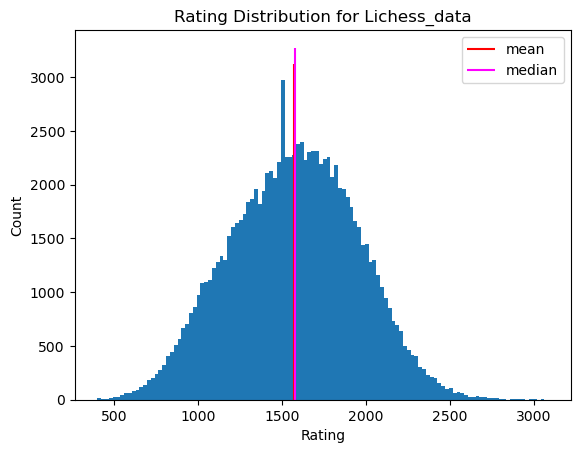

In [16]:
plot_rating_distribution(extract_rating_list(lichess_data), "Lichess_data")

In [17]:
# Check for spike in distribution
lichess_rating_list = extract_rating_list(lichess_data)
lichess_rating_list["rating"].value_counts()

rating
1500    857
1582    134
1691    130
1601    128
1679    124
       ... 
670       1
2686      1
2548      1
418       1
2615      1
Name: count, Length: 2278, dtype: int64

In [18]:
del lichess_rating_list

There is a spike at 1500 rating, there are many players at that rating. This can be explained by the fact that the lichess server assigns new players a starting rating of 1500.

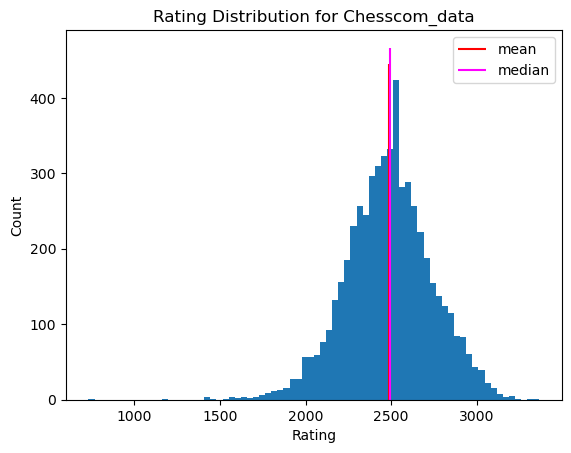

In [19]:
plot_rating_distribution(extract_rating_list(chesscom_data), "Chesscom_data")

In [20]:
chesscom_rating_list = extract_rating_list(chesscom_data)
chesscom_rating_list[(chesscom_rating_list["rating"] >= 2500) * (chesscom_rating_list["rating"] < 2600)]

,player,rating
1,"Rangel, Daniel",2531
3,"Novikov, Evgenij",2530
5,"Davidson, Kevin",2529
7,"Hirneise, Jens",2527
9,"Veiga, Jose Francisco R P Neves",2527
...,...,...
5459,nycjack1,2527
5466,"Mika, Tomasz",2580
5470,"Fernandez Lopez, Ruben",2548
5486,SONOFHOLYGOD,2506


In [21]:
chesscom_rating_list["rating"].value_counts()

rating
2518    18
2383    18
2516    18
2513    17
2534    17
        ..
2839     1
1865     1
3319     1
3094     1
1863     1
Name: count, Length: 1158, dtype: int64

In [22]:
def plot_cumulative_distribution_function(ratings):
    rating_sorted = np.sort(ratings)
    cdf = np.arange(len(ratings )) / float(len(ratings ))
    plt.plot(rating_sorted, cdf)
    plt.xlabel("Rating")
    plt.ylabel("Probability of ratings being less than or equal to x-axis values")
    plt.title("Cumulative density function for Chesscom ratings")
    plt.show()

In [23]:
chesscom_ratings = chesscom_rating_list["rating"]

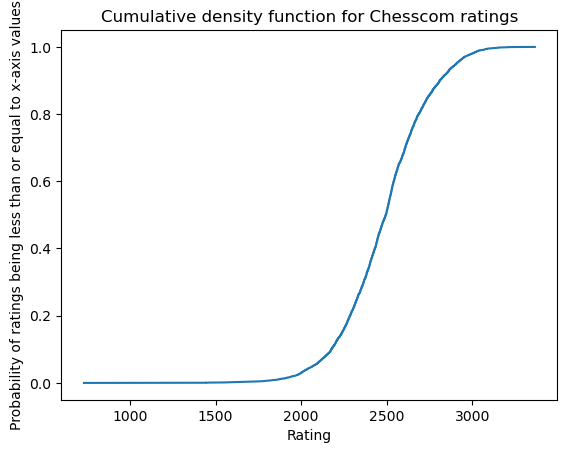

In [24]:
plot_cumulative_distribution_function(chesscom_ratings)

I had suspicions that the peak after 2500 hundred for the chesscom_data is an artifact of the chosen number of bins, because there is no rating value with a very large count. To check I decided to plot the cumulative density function for the ratings to see where the biggest growth is and check if it corresponds with the peak in the distribution plot. It does, so the peak is indeed in the data, there are many values grouped close enough to enter the bin for the peak.

In [25]:
del chesscom_rating_list
del chesscom_ratings

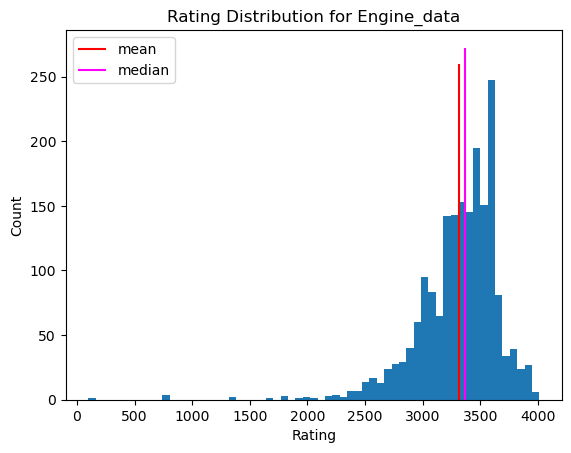

In [26]:
plot_rating_distribution(extract_rating_list(engine_data), "Engine_data")

Function to plot all three distributions on the same plot for comparison:

In [27]:
def plot_rating_distributions(x, y, z):
    ratings_x = extract_rating_list(x)["rating"]
    ratings_y = extract_rating_list(y)["rating"]
    ratings_z = extract_rating_list(z)["rating"]
    plt.hist(ratings_x, bins = "auto", color = "green", label = "Lichess", alpha = 0.5)
    plt.hist(ratings_y, bins = "auto", color = "blue",  label = "ChessCom", alpha = 0.5)
    plt.hist(ratings_z, bins = "auto", color = "red", label = "Engine", alpha = 0.5)
    plt.legend()
    plt.title("Rating Distributions Compared")
    plt.xlabel("Rating")
    plt.ylabel("Count")
    plt.show()

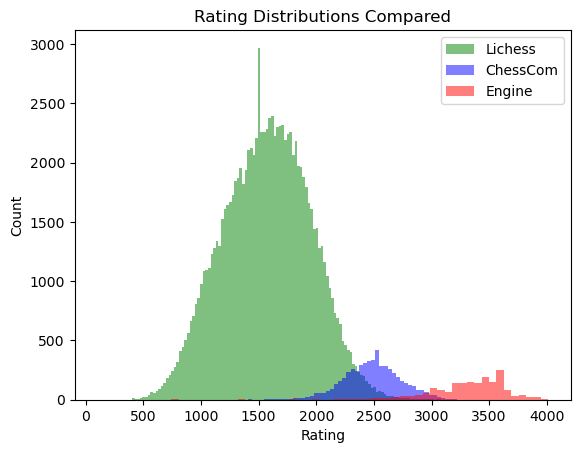

In [28]:
plot_rating_distributions(lichess_data, chesscom_data, engine_data)

Even taken with a grain(or a bucket) of salt, the results support the initial expectations of ratings and correspondingly level of play increasing from the lichess_data dataset, through chesscom_data, to the engine_data dataset.

#### How common are upsets in chess?

We will define an upset as a win by a player lower rated than his opponent by a significant margin. Online ratings fluctuate quite a bit, a player having a good day can win quite a bit of rating points, and conversely a player on tilt's rating could plummet in a couple of hours if he keeps playing. Having that in mind we will consider players within 50 rating points to be of pretty similar strength. We will define three rating intervals for difference in rating between opponents:
* from 50 to a 100 rating difference (small upset);
* from 100 to 200 rating difference (medium upset);
* more than 200 rating difference (large upset).<br>
Match-ups with vary high difference are not likely to happen often since if players choose who to play they are unlikely to pick someone much lower or much higher rated. Most players prefer to play someone pretty close to them in rating. Games with a large rating difference mostly happen in the early rounds of tournaments, where one does not pick one's opponents.
Below we define a function to look for games that fit our criteria: 

In [29]:
def get_upset_games_percentage(dataset, low, mid, high):
    small_upset = dataset[((dataset["rating_difference"] >= low) & (dataset["result_num"] == -1) & (dataset["rating_difference"] < mid)) |
                          ((dataset["rating_difference"] <= -low) & (dataset["result_num"] == 1) & (dataset["rating_difference"] > -mid))
    ]
    medium_upset = dataset[((dataset["rating_difference"] >= mid) & (dataset["result_num"] == -1) & (dataset["rating_difference"] < high)) |
                          ((dataset["rating_difference"] <= -mid) & (dataset["result_num"] == 1) & (dataset["rating_difference"] > -high))
    ]
    large_upset = dataset[((dataset["rating_difference"] >= high) & (dataset["result_num"] == -1))  |
                          ((dataset["rating_difference"] <= -high) & (dataset["result_num"] == 1)) ]
    all_games = len(dataset)
    small_upset_percentage = len(small_upset)/all_games * 100
    medium_upset_percentage = len(medium_upset)/all_games * 100
    large_upset_percentage = len(large_upset)/all_games * 100
    return [small_upset_percentage, medium_upset_percentage, large_upset_percentage]

In [30]:
upsets_lichess = get_upset_games_percentage(lichess_data, 50, 100, 200)
upsets_lichess

[8.264264792892174, 3.4233547017950485, 1.1266118030189676]

In [31]:
def plot_upset_percentages(upsets, data_source):
    labels = ["50-100", "100-200", "200 +"]
    plt.bar(labels, upsets)
    plt.xlabel("Rating gap, upper value not included")
    plt.ylabel("Percentage of all games")
    plt.title(f"Upset percentages for {data_source}")
    plt.show()  

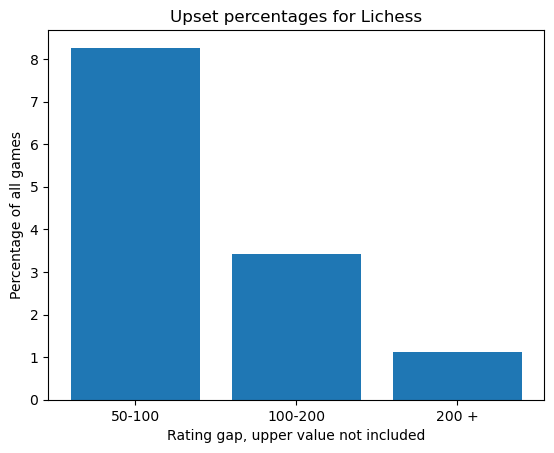

In [32]:
plot_upset_percentages(get_upset_games_percentage(lichess_data, 50, 100, 200), "Lichess")

Here the results fit the expectations, bigger upset are rarer.

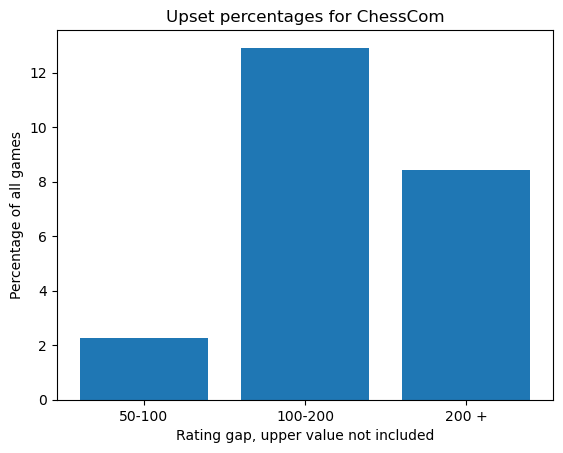

In [33]:
plot_upset_percentages(get_upset_games_percentage(chesscom_data, 50, 100, 200), "ChessCom")

Here we see a pretty big anomaly: the smallest upset is the most rare. Let's investigate and try to find a possible reason.

In [34]:
small_upset = chesscom_data[((chesscom_data["rating_difference"] >= 100) & (chesscom_data["result_num"] == -1) & (chesscom_data["rating_difference"] < 200)) |
                          ((chesscom_data["rating_difference"] <= -100) & (chesscom_data["result_num"] == 1) & (chesscom_data["rating_difference"] > -200))]
small_upset["termination"].isna().sum()

1571

In [35]:
len(small_upset)

17440

In [ ]:
print(small_upset["termination"].value_counts().to_string())

I have decided to look at the percentage of games that allow for upsets to happen. If there are less chances for upsets for some reason, there will be less upsets.

In [37]:
def get_possible_upset_games_percentage(dataset, low, mid, high):
    small_upset_possible = dataset[((dataset["rating_difference"] >= low)  & (dataset["rating_difference"] < mid)) |
                          ((dataset["rating_difference"] <= -low) & (dataset["rating_difference"] > -mid))
    ]
    medium_upset_possible= dataset[((dataset["rating_difference"] >= mid) & (dataset["rating_difference"] < high)) |
                          ((dataset["rating_difference"] <= -mid)& (dataset["rating_difference"] > -high))
    ]
    large_upset_possible = dataset[(dataset["rating_difference"] >= high)  |
                          (dataset["rating_difference"] <= -high)  ]
    all_games = len(dataset)
    small_upset_percentage = len(small_upset_possible)/all_games * 100
    medium_upset_percentage = len(medium_upset_possible)/all_games * 100
    large_upset_percentage = len(large_upset_possible)/all_games * 100
    return [small_upset_percentage, medium_upset_percentage, large_upset_percentage]

In [38]:
possible_upsets_chesscom = get_possible_upset_games_percentage(chesscom_data, 50, 100, 200)

In [39]:
possible_upsets_chesscom

[3.4293623887844378, 38.59716650135457, 57.334675568846315]

In [40]:
del possible_upsets_chesscom

In [41]:
possible_upsets_lichess = get_possible_upset_games_percentage(lichess_data, 50, 100, 200)

In [42]:
possible_upsets_lichess

[19.65556191230618, 9.699912472433708, 6.03793513180478]

In [43]:
del possible_upsets_lichess

In [44]:
chesscom_data[(chesscom_data["rating_difference"]>=200)|(chesscom_data["rating_difference"]<=-200)]

,Unnamed: 0,date,white,black,result,result_num,white_elo,black_elo,rating_difference,moves,number_of_moves,termination
0,0,2024-01-02,"Carlsen, Magnus","Santos Flores, Alberto",1-0,1,3366,2532,834,1. e4 e6 2. b3 d5 3. Bb2 dxe4 4. Nc3 Nf6 5. g4...,22,NaN
1,1,2024-01-02,"Rangel, Daniel","Nakamura, Hikaru",0-1,-1,2531,3238,-707,1. c4 g6 2. g3 Bg7 3. Bg2 d6 4. Nc3 Nc6 5. e4 ...,37,NaN
2,2,2024-01-02,Nihal Sarin,"Kambrath, Yannick",1-0,1,3203,2531,672,1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 Nf6 5. O-...,22,NaN
3,3,2024-01-02,"Novikov, Evgenij","Vachier-Lagrave, Maxime",0-1,-1,2530,3187,-657,1. d4 Nf6 2. c4 e6 3. Nc3 d5 4. cxd5 exd5 5. B...,36,NaN
4,4,2024-01-02,"Firouzja, Alireza","Rodriguez Fontecha, Marcos",1-0,1,3160,2530,630,1. d4 d5 2. Bg5 Bf5 3. e3 c6 4. Nd2 Nd7 5. Ngf...,44,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
135075,135075,2024-07-09,Navyblue1,schondeln,0-1,-1,2134,2343,-209,1. d4 d5 2. c4 c6 3. e3 Nf6 4. Nc3 a6 5. cxd5 ...,65,schondeln won by resignation
135090,135090,2024-07-09,dodorox,Ninocanina,1-0,1,2174,1958,216,1. d4 d5 2. c4 e6 3. Nc3 Nf6 4. cxd5 exd5 5. B...,74,dodorox won by resignation
135093,135093,2024-07-09,OverallStranger,c63_amg,1/2-1/2,0,2446,2764,-318,1. e4 c5 2. Nc3 e6 3. f4 d5 4. Nf3 a6 5. g3 Nf...,99,Game drawn by repetition
135096,135096,2024-07-09,GoltsevDmitry2000,jbking07,1-0,1,2787,2491,296,1. e4 c5 2. Nf3 g6 3. d4 cxd4 4. Qxd4 Nf6 5. N...,109,GoltsevDmitry2000 won by resignation


In [45]:
(len(chesscom_data[(chesscom_data["rating_difference"] >= 200)|(chesscom_data["rating_difference"] <= -200)]) / len(chesscom_data)) * 100

57.334675568846315

More then half of the games from ChessCom are contested with a rating gap equal or larger to 200 ratings points.

Indeed, for some reason there are much less games which allow for a small upset to happen in the chesscom_data dataset. Conversely, there are many games with large ratings gaps. This creates the anomalous situation where a smaller upset becomes less likely. I think, the explanation of all that is rooted in the fact that all the games from ChessCom are from the "Titled Tuesday" tournament. The tournament has specific pairing rules and it seems that they results in many "mismatches".

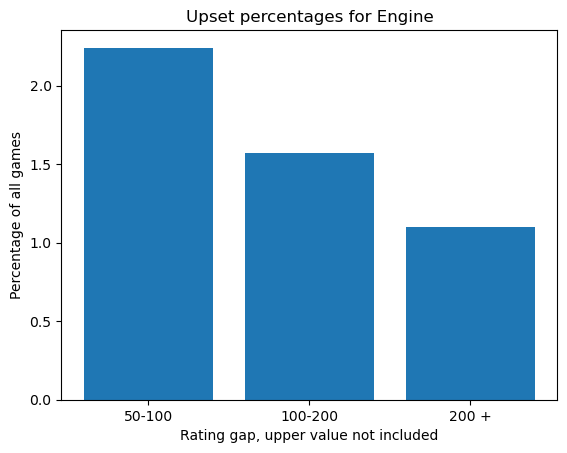

In [46]:
plot_upset_percentages(get_upset_games_percentage(engine_data, 50, 100, 200), "Engine")

At the highest level of play in the engine games the percentages of upsets again fit our expectations - larger upsets are proportionally rarer.  Looking at the scale of the y-axis, however reveals that in engine play upsets overall are much rarer.

#### What are the squares most often occupied and least often occupied by each piece?

We will focus on the pieces: kings, queens, rooks, bishops and knights and ignore the pawns. We will mostly look at the lichess_data dataset.

Below we define a function to count how many times a  certain piece occupies each square:

In [47]:
def extract_piece_frequencies(moves_column, piece, percentage = False):
    squares = [f"{file}{rank}" for rank in "12345678" for file in "abcdefgh"]
    piece_frequencies = {square: 0 for square in squares}
    
    piece_notation = {
        "king": "K",
        "queen": "Q",
        "rook": "R",
        "bishop": "B",
        "knight": "N"
    }

    piece_pattern = re.compile(rf'{piece_notation[piece]}[a-h][1-8]')

    # Count regular piece frequencies, not including castling 
    for game_notation in moves_column:
        piece_frequencies = count_piece_frequencies(game_notation, piece_pattern, piece_frequencies)

    # Count piece frequencies affected by castling if needed
    if piece in {"king", "rook"}:
        for game_notation in moves_column:
            piece_frequencies = apply_castling_logic(game_notation, piece, piece_frequencies)
    
    if percentage:
        total_moves = sum(piece_frequencies.values())
        piece_frequencies = {square: (count / total_moves) * 100 for square, count in piece_frequencies.items()}

    return piece_frequencies

def count_piece_frequencies(game_notation, piece_pattern, piece_frequencies):
    moves = re.findall(piece_pattern, game_notation)
    for move in moves:
        square = move[1:]
        piece_frequencies[square] += 1
    return piece_frequencies

def apply_castling_logic(game_notation, piece, piece_frequencies):
    moves = game_notation.split()
    for index, move in enumerate(moves):
        piece_frequencies = add_castling_frequencies(piece_frequencies, move, piece, index)
    return piece_frequencies

def add_castling_frequencies(piece_frequencies, move, piece, index):
    if piece == "king":
        # Kingside castle
        if move in {"O-O", "0-0"}:
            if index % 2 == 0:  # White move (even index)
                piece_frequencies["g1"] += 1
            else:  # Black move (odd index)
                piece_frequencies["g8"] += 1
        # Queenside castle
        elif move in {"O-O-O", "0-0-0"}:
            if index % 2 == 0:  # White move (even index)
                piece_frequencies["c1"] += 1
            else:  # Black move (odd index)
                piece_frequencies["c8"] += 1
    elif piece == "rook":
        # Kingside castle
        if move in {"O-O", "0-0"}:
            if index % 2 == 0:  # White move (even index)
                piece_frequencies["f1"] += 1
            else:  # Black move (odd index)
                piece_frequencies["f8"] += 1
        # Queenside castle
        elif move in {"O-O-O", "0-0-0"}:
            if index % 2 == 0:  # White move (even index)
                piece_frequencies["d1"] += 1
            else:  # Black move (odd index)
                piece_frequencies["d8"] += 1
    return piece_frequencies


And this is a function to plot the chess board as a heat map and visualize the results:

In [48]:
def plot_chessboard_heatmap(frequencies, piece, data_source = "Lichess"):
    heatmap_data = np.zeros((8, 8))
    squares = [f"{file}{rank}" for rank in "12345678" for file in "abcdefgh"]
    # create a dictionary where each key is a chessboard square (e.g., 'a1', 'b2'),
    # and each value is a tuple representing the row and column indices of that square
    #  in a matrix representation of the chessboard
    square_to_index = {square: (7 - (ord(square[1]) - ord("1")), ord(square[0]) - ord("a")) for square in squares}

    for square, frequency in frequencies.items():
        row, col = square_to_index[square]
        heatmap_data[row, col] = frequency
    
    plt.figure(figsize = (8, 8))
    sns.heatmap(heatmap_data, fmt = ".0f", cmap = "coolwarm", cbar = True, square = True,
                xticklabels = list("abcdefgh"), yticklabels = list("87654321"))
    plt.title(f'Heatmap of Placement Frequencies for {piece.capitalize()+ "s"}, source - {data_source}')
    plt.show()

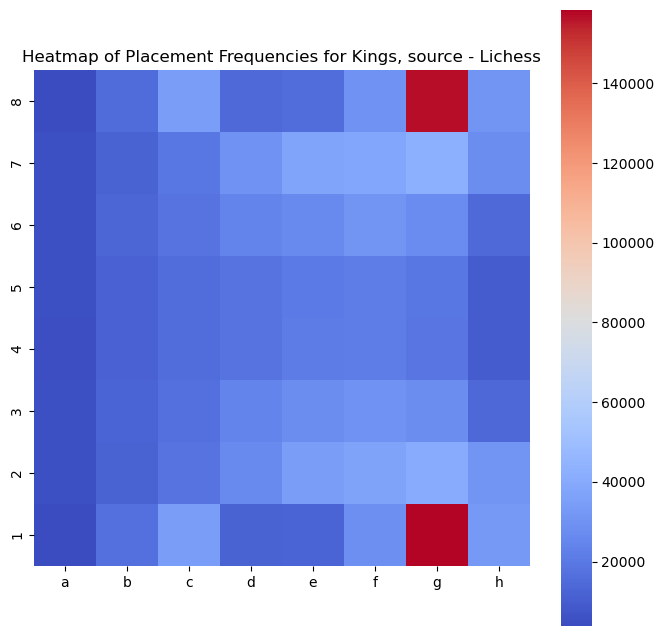

In [49]:
plot_chessboard_heatmap(extract_piece_frequencies(lichess_data["moves"], "king"), "king")

The most popular squares for kings are by far the "g1" and "g8" squares. These are the squares where the kings end up when a player castles Kingside. One possible explanation is that many games end early soon after the opponents have castled. The kings do not have much time to "wander" around. The king is also a "slow" piece, it can only move one square in any direction, hence squares that are far from the starting square for the king and the square where the king lands after castling are visited less frequently. This explains the low frequencies all along the "a" file. Let's look at average game length and decide if it lands more support to our hypothesis.

###### Game Length

In [50]:
lichess_data["number_of_moves"].mean()

33.51643709017295

In [51]:
lichess_data["number_of_moves"].describe().T

count    204507.000000
mean         33.516437
std          15.116285
min           1.000000
25%          23.000000
50%          32.000000
75%          42.000000
max         175.000000
Name: number_of_moves, dtype: float64

In [52]:
def plot_game_length_distributions(
        number_of_moves_column,
        data_source,
        label = None, 
        show = True,
        legend = False, 
        color = None, 
        alpha = 1):
    plt.hist(number_of_moves_column, bins = "auto", color = color, alpha = alpha, label = label )
    plt.xlabel("game length in number of moves")
    plt.ylabel("count")
    plt.title(f"Distribution of game length in number of moves, {data_source}.")
    if legend:
        plt.legend()
    if show:
        plt.show()

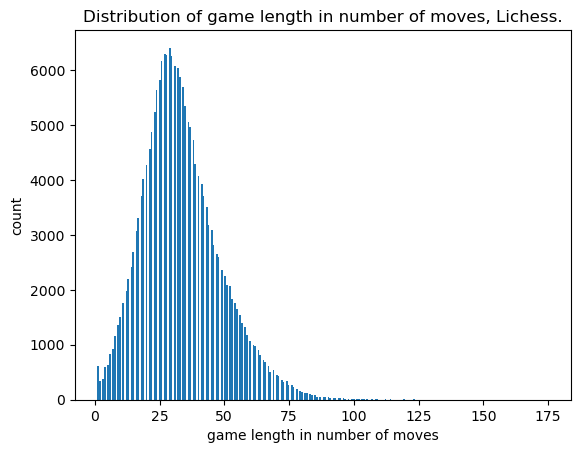

In [53]:
plot_game_length_distributions(lichess_data["number_of_moves"], "Lichess")

In [54]:
# Abandoned games(after just one move)
lichess_data[lichess_data["number_of_moves"]== 1]

,Unnamed: 0,date,white,black,result,result_num,white_elo,black_elo,rating_difference,moves,number_of_moves,eco,opening,time_control,termination
2,2,2024-05-01,Joao_Almeida2005,Kauani_Plnr,1-0,1,1918,1655,263,1. e4,1,B00,King's Pawn Game,300+0,Time forfeit
27,27,2024-05-01,NunoRazec,levargas,1-0,1,1800,1459,341,1. e4,1,B00,King's Pawn Game,420+3,Time forfeit
29,29,2024-05-01,Caique-Emmerich,GabrielAlvesSangy,1-0,1,1977,1726,251,1. e4,1,B00,King's Pawn Game,420+3,Time forfeit
78,78,2024-05-01,Hueter-der-Feste,Dowser27,0-1,-1,1335,1379,-44,1. e4 e5,1,C20,King's Pawn Game,60+0,Time forfeit
216,216,2024-05-01,IDKHTPC4444444,Sanjeev_2013,0-1,-1,856,951,-95,1. e4 e5,1,C20,King's Pawn Game,900+10,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201096,201096,2024-05-01,aleks6161,vicc0406,0-1,-1,1500,1527,-27,1. a3 e6,1,A00,Anderssen's Opening,180+2,Time forfeit
201194,201194,2024-05-01,edgarvalderrama6727,bobburnside,0-1,-1,1864,1826,38,1. e4 g6,1,B06,Modern Defense,300+0,Time forfeit
201904,201904,2024-05-01,tonyortega67,Badger5,0-1,-1,2066,2014,52,1. e4 c5,1,B20,Sicilian Defense,300+0,Time forfeit
202768,202768,2024-05-01,matt_zentrix,queenkiller06,1-0,1,1015,1106,-91,1. e3 g6,1,A00,Van't Kruijs Opening,300+0,Normal


In [55]:
lichess_data[lichess_data["number_of_moves"]== 1]["time_control"].value_counts()

time_control
180+0      125
600+0      106
60+0        84
300+0       80
180+2       65
120+1       31
420+2       19
300+2       15
600+5        9
300+3        9
60+1         8
600+2        8
-            6
180+1        6
15+0         6
420+3        5
90+0         5
900+10       5
480+0        3
300+5        3
240+3        3
420+0        2
30+0         2
1800+0       2
1500+3       1
360+0        1
600+8        1
120+0        1
5400+3       1
1800+30      1
960+3        1
45+0         1
900+0        1
1260+13      1
600+3        1
1800+20      1
420+5        1
360+7        1
240+8        1
Name: count, dtype: int64

In [56]:
lichess_data["number_of_moves"].kurtosis()

1.106178873625439

Indeed, the distribution of game lengths is platykurtic with few outliers. The average game length is 33 moves and there a number of abandoned games, my guess for those base on the time control is that many people click on a game without looking at the time control and abandon it when they realize the time control is a long one. All these support our hypothesis that the games rarely reach the endgame where kings have more time and opportunity to "wander" around. Let us look at more heat maps of piece frequencies.

While we are discussing game lengths let us, look at the average game length and the distributions of game lengths for engine games. We will need it later.

In [57]:
engine_data["number_of_moves"].mean()

69.70707196544994

In [58]:
engine_data["number_of_moves"].describe().T

count    48162.000000
mean        69.707072
std         31.108963
min          1.000000
25%         50.000000
50%         63.000000
75%         81.000000
max        379.000000
Name: number_of_moves, dtype: float64

The average game length for the engine games is 69.70 compared to 33.52 for the lichess_data. This is possibly because humans make more mistakes so their games are shorter. Humans also play much shorter time controls usually, they can lose on time before their game becomes too long. 
As we have already established decisive games happen with half the frequency in the engine_data dataset compared to human games. It seems like it is rough to be an engine, they have two play twice as long (in terms of number of moves) chasing victory(or defeat), but get rewarded with a decisive result half as often.

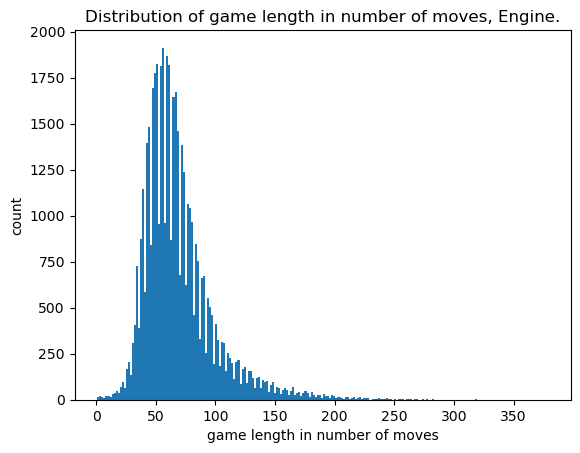

In [59]:
plot_game_length_distributions(engine_data["number_of_moves"], "Engine")

That is one interesting distribution. It is right-skewed there many more outliers with larger number of moves. There are many minor peaks. These correspond to common game lengths. When a computer game reaches a position that is one in the chess tablebase(a collection of positions with few pieces and known outcomes if played perfectly) its result is decided by the evaluation of the corresponding tablebase position. Maybe these known positions are often reached at certain game lengths.

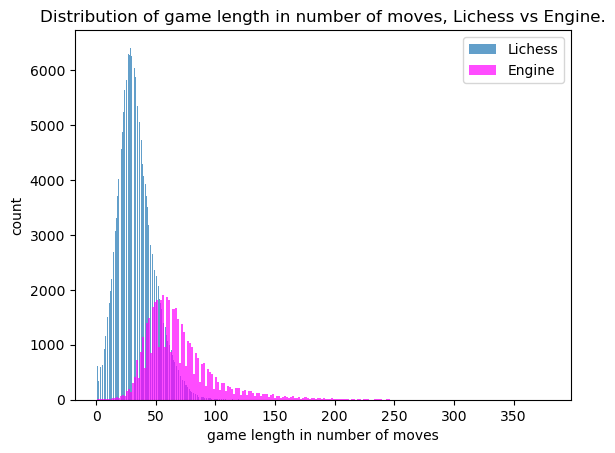

In [60]:
plot_game_length_distributions(lichess_data["number_of_moves"], "",label = "Lichess", show = False, alpha= 0.7)
plot_game_length_distributions(engine_data["number_of_moves"], "Lichess vs Engine",alpha= 0.7, legend = True, label = "Engine", color = "magenta")

In [61]:
engine_data["number_of_moves"].skew()

2.001929925591373

In [62]:
engine_data["number_of_moves"].value_counts()

number_of_moves
56     973
58     962
60     954
53     953
57     939
      ... 
341      1
314      1
255      1
265      1
230      1
Name: count, Length: 298, dtype: int64

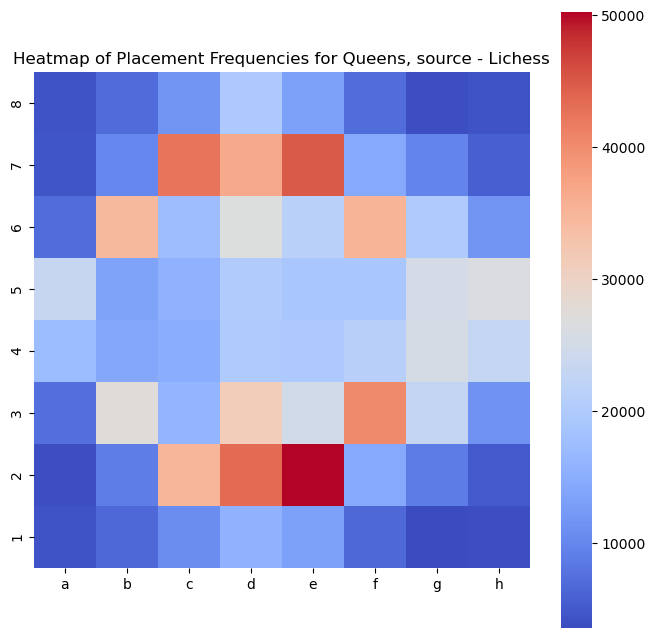

In [63]:
plot_chessboard_heatmap(extract_piece_frequencies(lichess_data["moves"], "queen"), "queen")

Squares that are immediately accessible from the initial position of the queens are much more popular.

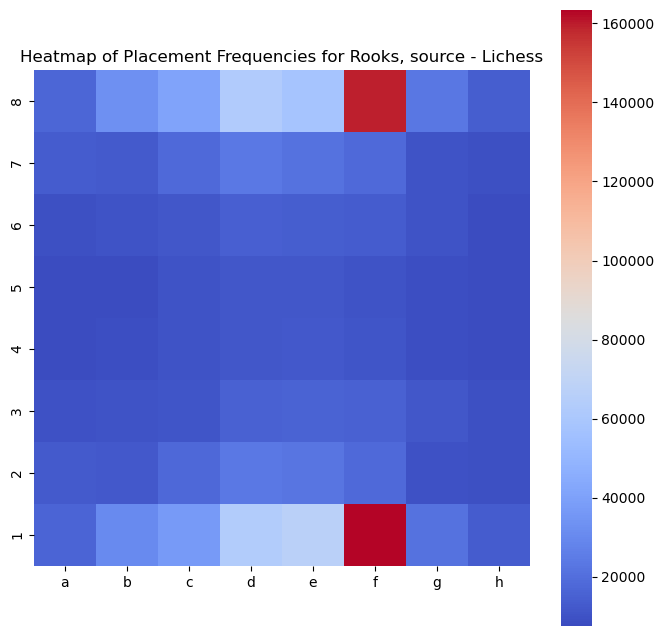

In [64]:
plot_chessboard_heatmap(extract_piece_frequencies(lichess_data["moves"], "rook"), "rook")

Again the squares where the rooks end up after castling are the most popular squares, as expected.

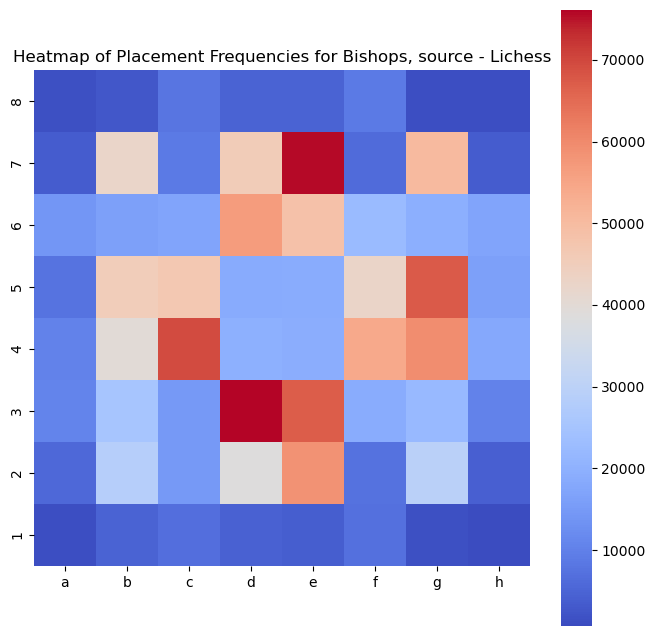

In [65]:
plot_chessboard_heatmap(extract_piece_frequencies(lichess_data["moves"], "bishop"), "bishop")

Here a slight surprice is the fact that the "g7" square is more popular than "g2" for bishops.

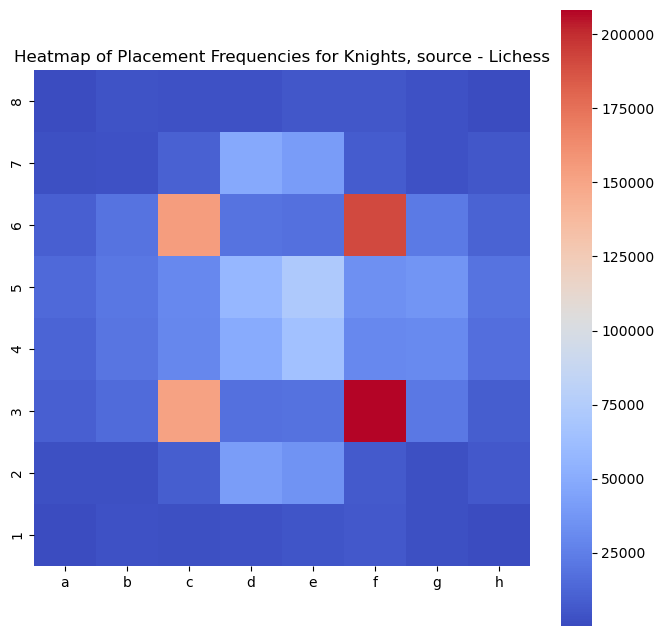

In [66]:
plot_chessboard_heatmap(extract_piece_frequencies(lichess_data["moves"], "knight"), "knight")

Knights, it seem are very "attracted" to "f3", "c3", "f6" and "c6" and the central squares. On the contrary, the edges and especially the corners of the board are quite unpopular destinations. This is expected since a knight has very limited mobility at those squares. For example, from the corner "h1" the knight can only go to two squares contrasted with the normal eight if it is in the middle of the board.

Let's compare popular squares for queens in the lichess dataset and the engine dataset. To account for the difference in size of the two datasets we are using a "percentage" parameter, which makes the `extract_piece_frequencies()` function to return a matrix where each value is not the count of the corresponding piece being moved to that square, but the percentage of all moves for that piece.

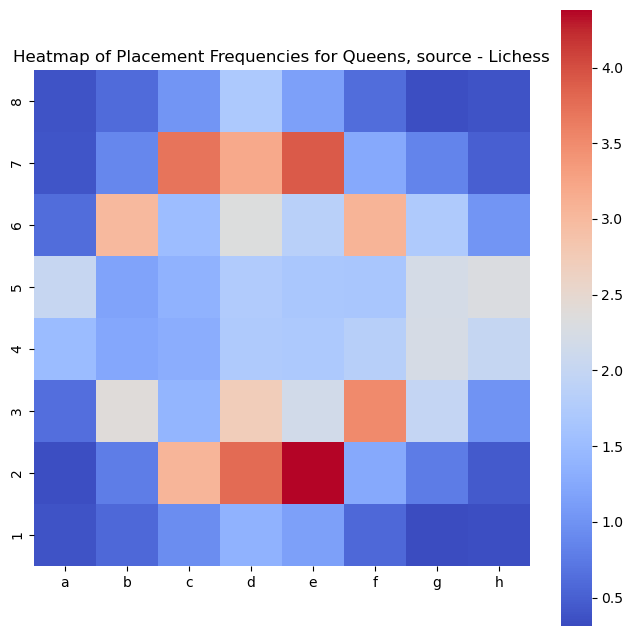

In [67]:
plot_chessboard_heatmap(extract_piece_frequencies(lichess_data["moves"], "queen", percentage = True), "queen")

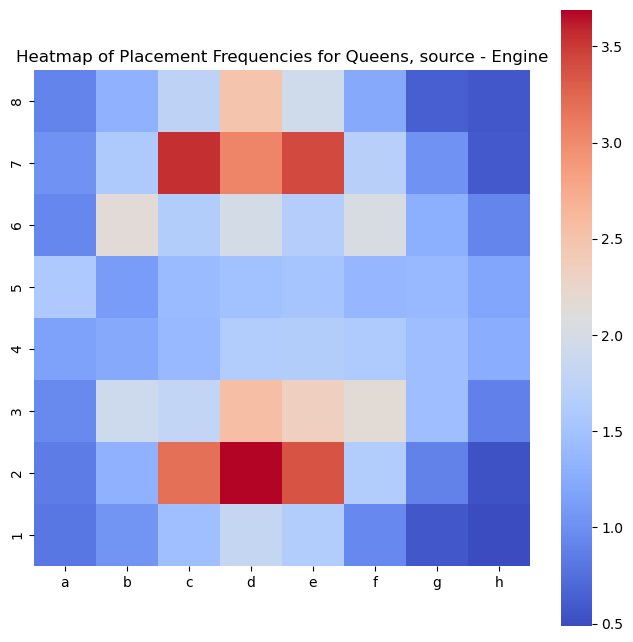

In [68]:
plot_chessboard_heatmap(extract_piece_frequencies(engine_data["moves"], "queen", percentage = True), "queen", data_source =  "Engine")

In [69]:
# Making sure percentages add up to 100 as a sanity check
sum(extract_piece_frequencies(engine_data["moves"], "queen", percentage = True).values())

100.00000000000001

This is why we did't not jump directly at comparisons. It is hard to notice any patterns and trends aside from maybe that humans prefer the "e2" square for the white queen and engines prefer "d2".

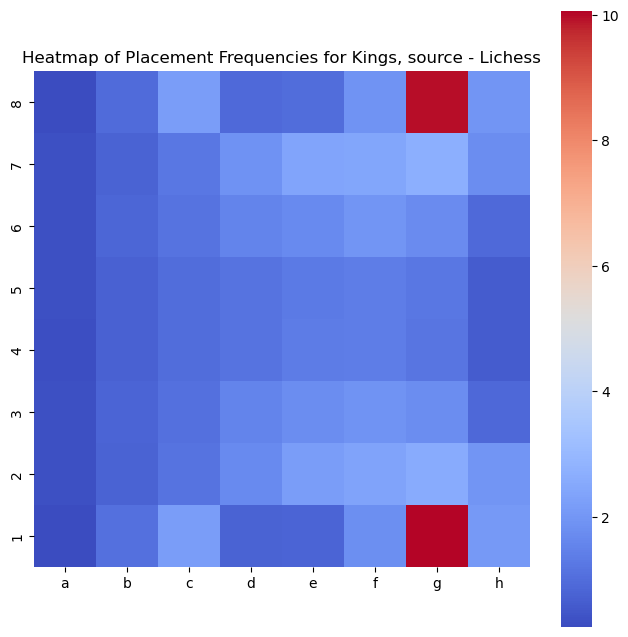

In [70]:
plot_chessboard_heatmap(extract_piece_frequencies(lichess_data["moves"], "king", percentage = True), "king")

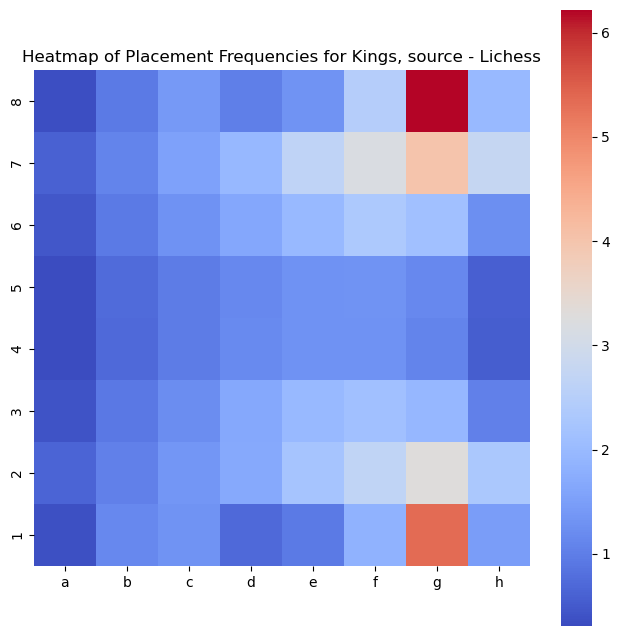

In [71]:
plot_chessboard_heatmap(extract_piece_frequencies(engine_data["moves"], "king", percentage = True), "king")

As alredy discussed engine games are longer, so their kings have had more time to reach wider range of squares. Lets subtract the engine values from the lichess values to see where the largest differences are.

Function to subtract the values of two dictionaries:

In [72]:
def subtract_dict_values(dict1, dict2):
    # Convert dictionary values to numpy arrays
    keys = list(dict1.keys())
    values1 = np.array(list(dict1.values()))
    values2 = np.array(list(dict2.values()))

    # Subtract the numpy arrays
    difference_values = values1 - values2

    # Map the result back to a dictionary
    difference = dict(zip(keys, difference_values))
    return difference 

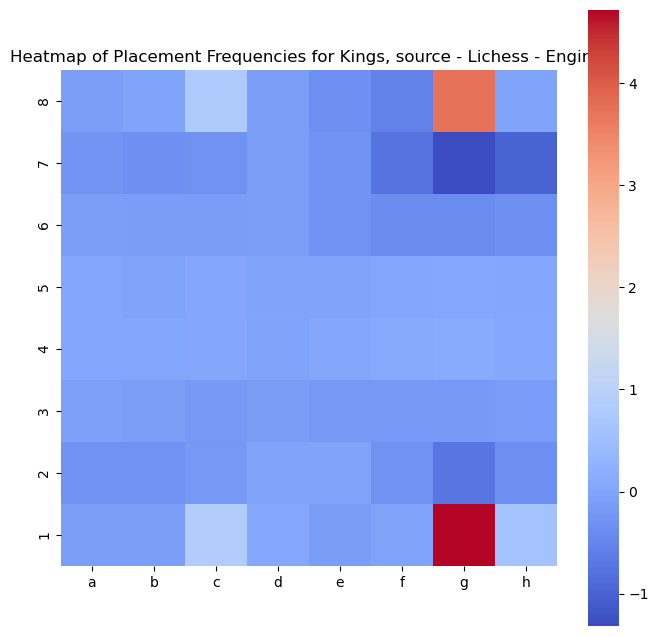

In [73]:
# Extract piece frequencies from both data sources
lichess_king_frequencies = extract_piece_frequencies(lichess_data["moves"], "king", percentage = True)
engine_king_frequencies = extract_piece_frequencies(engine_data["moves"], "king", percentage = True)

# Subtract the frequencies
frequency_difference = subtract_dict_values(lichess_king_frequencies, engine_king_frequencies)

# Plot the heatmap
plot_chessboard_heatmap(frequency_difference, "king", data_source =  "Lichess - Engine ")

In [74]:
frequency_difference

{'a1': -0.09967043059617448,
 'b1': -0.10446148719409365,
 'c1': 0.8520508347638007,
 'd1': 0.05051999993836975,
 'e1': -0.13683533579374108,
 'f1': -0.032849054693375734,
 'g1': 4.716821199009207,
 'h1': 0.5834480889647637,
 'a2': -0.3166881722917104,
 'b2': -0.28946837465665454,
 'c2': -0.2039631366901371,
 'd2': -0.017571057708124282,
 'e2': -0.017487661336859084,
 'f2': -0.32211017019541366,
 'g2': -0.7433082827193456,
 'h2': -0.36745638036308703,
 'a3': -0.07487399027492897,
 'b3': -0.10750109889280657,
 'c3': -0.16422267952802616,
 'd3': -0.1345996869370918,
 'e3': -0.2039033965183299,
 'f3': -0.18901080341835863,
 'g3': -0.16584881486706582,
 'h3': -0.15399426282006112,
 'a4': 0.0060332815482900815,
 'b4': 0.0067870556503608626,
 'c4': 0.037870625531338686,
 'd4': -0.02715845792499727,
 'e4': 0.028099998576606167,
 'f4': 0.08824678290446752,
 'g4': 0.11398434708756988,
 'h4': 0.07206171740702194,
 'a5': 0.005886768577912982,
 'b5': -0.030364221505892908,
 'c5': 0.045498251749605

In [75]:
del frequency_difference

A lot of the values are negative indicating that indeed the kings of engine players "visit" more squares. There are some ralatively large positive values for the "g1" and "g8" squares (the squares where kings end up after short castling) indicating that maybe human players castle kingside more often. However, further investigation is required to be more certain. Allthough generally, humans often make moves base on general principles and are taught to castle as early as possible, so they might ignore a stronger move to castle, while an engine player very concretely and will always make the best move, possibly delaying castling.

#### Is it important to control and fight for the center of the board in a chess game?

If one is not a chess player it might be hard to imagine why controlling the center of the board could be important. To illustrate why this could be the case we will look at the history of chess. The earliest known predecessor, called chaturanga was a turn based strategy game popular in ancient India. The goal of chaturanga was to create a game modelled on battles fought on battlefields in the real world. The strategy to be successful in the game was closely related to the strategy for controlling an army. In the real world  battles whoever controls the center of the battlefield restricts the mobility of the opposing forces, because they must take the long way around the center to redeploy their armies. Exactly the same is true in chess. The side controlling the center usually enjoys a large advantage. One of the first tips given to novice players is to focus on moves that influence the center of the board. The groundbreaking AI Alpha Zero created by the Google Deepmind team showed that it valued control of the center greatly by being often ready to sacrifice material to achieve a more dominant position in the center of the board. Let us see if the data in the datasets supports what every seasoned chess player knows, or not.
Our method will be the following:
* we will define the center of the board to be the following squares: "e4", "d4, "e5", "d5";
* we will create two variables to store the center control value for each player;
* we will go through the games and increment by one the variable whenever the corresponding player places their pieces or pawns in the center;
* when a capture occurs on a central square we will increment the corresponding central control variable by two, because the capturing player puts one of their pieces in the center while removing one of the opponent's pieces;
* then we will add the variables to the datasets and create another column for their difference;
* from there we will look if there is a relation between winning and having a higher center control value
* to do this we will run an ANOVA test to see if the central control variables' means differ in a statistically significant way if grouped by game outcome (category).

A function to implement what is described above:

In [76]:
def score_central_control(game):
    white_score = 0
    black_score = 0
    
    # Remove move numbers and periods
    game_clean = re.sub(r'\d+\.\s*', '', game).strip()

    # Split the game sting by spaces to extract moves
    moves = game_clean.split()

    # Define central squares
    central_squares = {"e4", "e5", "d4", "d5"}

    for i, move in enumerate(moves):
        if len(move) >= 2:
            move_end = move.split("x")[-1][:2]
        
        if move_end in central_squares:
            if "x" in move: # Capturing move
                if i % 2 == 0: # White's move
                    white_score += 2
                else: # Black's move
                    black_score += 2
            else: # Non capturing move
                if i % 2 == 0: # White's move
                    white_score += 1
                else: # Black's move
                    black_score += 1

    return white_score, black_score

In [77]:
# Apply the function directly to the DataFrame and unpack results
lichess_data[["white_central_score", "black_central_score"]] = lichess_data["moves"].apply(score_central_control).apply(pd.Series)

In [78]:
lichess_data[["moves", "white_central_score", "black_central_score"]]

,moves,white_central_score,black_central_score
0,1. e4 e5 2. Nf3 Qf6 3. Bc4 Bc5 4. O-O d6 5. Nc...,1,1
1,1. e4 c5 2. Nf3 g6 3. Bc4 Bg7 4. Nc3 e6 5. O-O...,4,8
2,1. e4,1,0
3,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. d3 Bc5 5. c3...,2,3
4,1. e4 c6 2. c3 d5 3. e5 Bf5 4. d4 e6 5. Nf3 c5...,9,7
...,...,...,...
204502,1. e4 g6 2. d4 Bg7 3. Nf3 d6 4. Be3 Nc6 5. Bb5...,4,3
204503,1. e4 g6 2. Nf3 Bg7 3. d4 e6 4. Bd3 Ne7 5. O-O...,5,6
204504,1. e4 e5 2. Bc4 Nc6 3. d3 Nf6 4. Nf3 Bc5 5. Ng...,3,3
204505,1. e4 Nc6 2. f4 e5 3. fxe5 Nxe5 4. Nf3 Ng6 5. ...,5,4


Below we calculate the difference in central control from white's point of view. It will be positive if white's center control was higher and negative if it was lower. 

In [79]:
lichess_data["central_score_difference"] = lichess_data["white_central_score"]- lichess_data["black_central_score"]

In [80]:
lichess_data["white_central_score"].describe()

count    204507.00000
mean          5.86667
std           2.95194
min           0.00000
25%           4.00000
50%           6.00000
75%           8.00000
max          23.00000
Name: white_central_score, dtype: float64

In [81]:
lichess_data["black_central_score"].describe()

count    204507.000000
mean          5.446748
std           2.990568
min           0.000000
25%           3.000000
50%           5.000000
75%           7.000000
max          21.000000
Name: black_central_score, dtype: float64

In [82]:
# Define the model for White Control
model_white = ols('white_central_score ~ C(result)', data = lichess_data).fit()

# Perform ANOVA
anova_white = sm.stats.anova_lm(model_white, typ = 2)

# Display the results
print("ANOVA results for White Control:")
print(anova_white)

ANOVA results for White Control:
                 sum_sq        df           F         PR(>F)
C(result)  1.209906e+04       2.0  698.973501  2.968242e-303
Residual   1.769956e+06  204504.0         NaN            NaN


In [83]:
# Define the model for Black Control
model_black = ols('black_central_score ~ C(result)', data = lichess_data).fit()

# Perform ANOVA
anova_black = sm.stats.anova_lm(model_black, typ = 2)

# Display the results
print("ANOVA results for Black Control:")
print(anova_black)

ANOVA results for Black Control:
                 sum_sq        df            F  PR(>F)
C(result)  2.118117e+04       2.0  1198.028297     0.0
Residual   1.807818e+06  204504.0          NaN     NaN


The ANOVA results for both White and Black's control of the center indicate that there are statistically significant differences in the means of the central control variable across different game outcomes (win, draw, loss). Specifically:

For White Control:

The ANOVA results show a very low p-value (close to zero), indicating that the differences in the central control variable are statistically significant across different game outcomes. This suggests a meaningful relationship between the control of the center and the game outcome.<br><br>
For Black Control:

Similarly, the ANOVA results show a p-value of 0.0, also indicating statistically significant differences in the central control variable across game outcomes. This further supports the notion of a significant relationship between control of the center and game outcome.
Interpretation:

These results support the hypothesis that the central control variable is related to the game outcome, as there is significant variation in the central control variable based on the outcome of the game. However, the residual sum of squares being much larger than the sum of squares explained by the game outcome suggests that while there is a relationship, other factors may also significantly influence the central control variable. This is to be expected since game outcome is influenced by many factors, and probably most of them influence the outcome more strongly than controlling the center.

#### How does similarity of board states change over the course of games?

##### Hypothesis

All chess games start from an identical position, but as moves are made the positions in different games quickly become more and more different from each other. One could imagine the space of all possible chess games as a tree stemming from the common initial position and quickly branching of and growing in width as the games progress. Game states in different games are diverging. 
I present the following hypothesis:
* After the initial divergence as the games progress further pieces and pawns are exchanged and differences between board states in different games are being erased. For example, if there is a different pawn structure (a certain pattern in how the pawns are positioned) in one game compared to another as more and more of the pawns in both games are captured or exchanged the pawn structure disappears. Or if one side has a king a rook and a bishop and the other side has a king a rook and a knight, if the bishop and the knights are exchanged a differentiating factor has disappeared and the boards states have become more alike. This convergence is not absolute, not all games will end in the same final position( although in high level competitive games it is not uncommon for the game to be contested until only the kings are left on the board), but I expect the board states are generally becoming more alike. If we return to the tree analogy, after growing from a common stem and exploding in width and number of branches, when the game is long the branches start to link back together and the tree becomes narrower.

##### Method to test the hypothesis

* We will select fifty games above a certain game length at from the engine_data dataset.
* We will extract the board state from the games using the python chess library at equal intervals of ten moves starting at move ten.
* We will create images of dimensions (224, 224, 3) that represent the chess board and encode different pawns and pieces with different color.
* We will feed the images to ResNet50 and take the feature map(the output of the last layer before the classification layer).
* We will convert the feature map to a feature vector with more manageable dimensions.
* We will compare the deep feature vectors for similarity using the cosine similarity metric.
* To land support to our hypothesis similarity should initially increase and then start decreasing.<br>
Note: This might not be the best way to this, or a way to do it at all. It is mostly experimentation. Additionally, the sample size of fifty games is way too small to be used for any conclusions. A larger sample, however will take quite a bit of time to process, at least on my machine. This experiment is more of a proof of concept of one possible approach.

Prepare data:

In [84]:
games_longer_than_60_moves = engine_data[engine_data["number_of_moves"] > 60].head(50)

In [85]:
games_longer_than_60_moves = games_longer_than_60_moves.reset_index(drop = True)

In [86]:
games_longer_than_60_moves = games_longer_than_60_moves.drop(columns=["Unnamed: 0"])

In [87]:
games_longer_than_60_moves.head(5)

,date,white,black,result,result_num,white_elo,black_elo,rating_difference,moves,number_of_moves,eco,opening,time_control,termination
0,2011-04-29,Greko 8.0,Zappa Mexico II,1/2-1/2,0,2501,2899,-398,1. Nf3 d5 2. c4 c6 3. e3 Nf6 4. Nc3 a6 5. Be2 ...,100,A09,Reti opening,5400+30,GUI adjudication
1,2011-04-30,Gaviota 0.83,Spark 1.0,0-1,-1,2544,2953,-409,1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 Nf6 5. O-...,61,C80,Ruy Lopez,5400+30,GUI adjudication
2,2011-04-30,Francesca 0.18,Protector 1.4,0-1,-1,2572,2959,-387,1. d4 d5 2. c4 c6 3. Nf3 Nf6 4. e3 e6 5. Bd3 d...,67,D27,QGA,5400+30,GUI adjudication
3,2011-04-30,Rotor 0.6,Gull 1.2,1/2-1/2,0,2602,2971,-369,1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 Nf6 5. d3...,159,C77,Ruy Lopez,5400+30,GUI adjudication
4,2011-04-30,Sjeng c't 2010,Dirty 240411,1-0,1,2980,2599,381,1. e4 c6 2. d4 d5 3. e5 Bf5 4. c3 e6 5. Be3 Qb...,80,B12,Caro-Kann,5400+30,GUI adjudication


In [88]:
def create_chess_board_image(board_state):
    img_size = 224
    square_size = 224 // 8

    # Bluish color for empty squares
    empty_square_color = [0, 127, 139]

    img_array = np.full((img_size, img_size, 3), empty_square_color, dtype = np.uint8)

    piece_colors = {
        "wP": [255, 255, 255],  # White Pawn
        "bP": [0, 0, 0],        # Black Pawn
        "wR": [192, 192, 192],  # Light Grey Rook
        "bR": [64, 64, 64],     # Dark Grey Rook
        "wN": [144, 238, 144],  # Light Green Knight
        "bN": [0, 100, 0],      # Dark Green Knight
        "wB": [173, 216, 230],  # Light Blue Bishop
        "bB": [0, 0, 139],      # Dark Blue Bishop
        "wQ": [204, 153, 255],  # Light Purple Queen
        "bQ": [128, 0, 128],    # Dark Purple Queen
        "wK": [255, 204, 204],  # Light Red King
        "bK": [139, 0, 0]       # Dark Red King
    }

    # Draw each piece
    for i in range(8):
        for j in range(8):
            piece = board_state[i][j]
            if piece != "--": # if square is not empty
                # Default to grey if piece is not recognized
                color = piece_colors.get(piece, [128, 128, 128])
                img_array[(7-i) * square_size:(8-i) * square_size, j * square_size:(j+1) * square_size] = color

    img = Image.fromarray(img_array, "RGB")
    return img

In [89]:
def board_to_image(board):
    board_state = [["--"] * 8 for _ in range(8)]

    for square, piece in board.piece_map().items():
        piece_str = f"{'w' if piece.color else 'b'}{piece.symbol().upper()}"
        row, col = chess.square_rank(square), chess.square_file(square)
        board_state[row][col] = piece_str

    return create_chess_board_image(board_state)

In [90]:
def game_to_board_states(game_text):
    # Use StringIO to simulate a file-like object, chess.pgn.read_game() is 
    # designed to operate on file objects or streams
    game_io = StringIO(game_text)

    game = chess.pgn.read_game(game_io)
    board = game.board()
    board_states = []

    for move in game.mainline_moves():
        board.push(move)
        board_states.append(board.copy())

    return board_states

In [91]:
def save_images_of_board_states(game_text, game_index, start_move = 10, end_move = 60, interval = 10, output_dir = "board_states"):
    os.makedirs(output_dir, exist_ok= True)

    board_states = game_to_board_states(game_text)
    move_count = 1

    for board in board_states:
        move_number = (move_count + 1) // 2 
        if (move_count % 2 == 1 and move_count // 2 + 1 >= start_move and 
            (move_count // 2 + 1 - start_move) % interval == 0 and 
            move_count // 2 + 1 <= end_move):
            board_image = board_to_image(board)
            image_filename = os.path.join(output_dir, f'game_{game_index}_move_{move_number}.png')
            board_image.save(image_filename)
            print(f'Saved board state at move {move_number} to {image_filename}')
        
        move_count += 1


In [92]:
def extract_images_from_moves_column(dataset):
    for index, row in dataset.iterrows():
        # Extract the game text from the 'moves' column
        game_text = row["moves"]
        save_images_of_board_states(game_text, index)

In [93]:
extract_images_from_moves_column(games_longer_than_60_moves)

Saved board state at move 10 to board_states\game_0_move_10.png
Saved board state at move 20 to board_states\game_0_move_20.png
Saved board state at move 30 to board_states\game_0_move_30.png
Saved board state at move 40 to board_states\game_0_move_40.png
Saved board state at move 50 to board_states\game_0_move_50.png
Saved board state at move 60 to board_states\game_0_move_60.png
Saved board state at move 10 to board_states\game_1_move_10.png
Saved board state at move 20 to board_states\game_1_move_20.png
Saved board state at move 30 to board_states\game_1_move_30.png
Saved board state at move 40 to board_states\game_1_move_40.png
Saved board state at move 50 to board_states\game_1_move_50.png
Saved board state at move 60 to board_states\game_1_move_60.png
Saved board state at move 10 to board_states\game_2_move_10.png
Saved board state at move 20 to board_states\game_2_move_20.png
Saved board state at move 30 to board_states\game_2_move_30.png
Saved board state at move 40 to board_st

In [94]:
def display_board_image_with_legend(board_state_image):
    piece_colors = {
    "white_pawn": [255, 255, 255],  # White Pawn
    "black_pawn": [0, 0, 0],        # Black Pawn
    "white_rook": [192, 192, 192],  # Light Grey Rook
    "black_rook": [64, 64, 64],     # Dark Grey Rook
    "white_Knight": [144, 238, 144],  # Light Green Knight
    "black_knight": [0, 100, 0],      # Dark Green Knight
    "white_bishop": [173, 216, 230],  # Light Blue Bishop
    "black_bishop": [0, 0, 139],      # Dark Blue Bishop
    "white_queen": [204, 153, 255],  # Light Purple Queen
    "black_queen": [128, 0, 128],    # Dark Purple Queen
    "white_king": [255, 204, 204],  # Light Red King
    "black_king": [139, 0, 0]       # Dark Red King
    }

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Display the preloaded chessboard image on the left
    ax1.imshow(board_state_image)
    ax1.set_title("Chessboard")
    ax1.axis("off")

    # Plot the legend on the right
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, len(piece_colors) * 0.1)
    ax2.axis("off")

    for i, (label, color) in enumerate(piece_colors.items()):
        ax2.add_patch(plt.Rectangle((0, i * 0.1), 0.2, 0.1, color = np.array(color) / 255.0))
        ax2.text(0.25, i * 0.1 + 0.05, label, verticalalignment = "center", fontsize = 12)

    ax2.set_title("Piece Color Legend")

    plt.tight_layout()
    plt.show()

In [95]:
# Read sample image
chess_board_image_sample = imread("board_states/game_0_move_10.png")
chess_board_image_sample.shape

(224, 224, 3)

Sample of chess board represented as an image with pieces encoded with different colors:

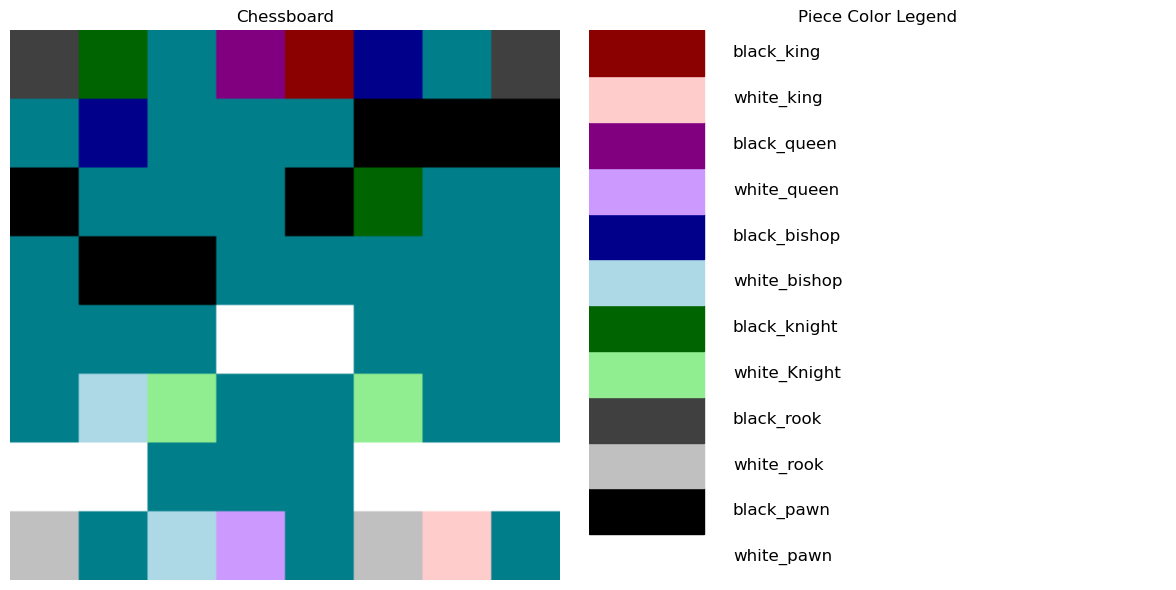

In [96]:
display_board_image_with_legend(chess_board_image_sample)

In [97]:
def image_generator(image_directory, batch_size = 6):
    # Get image paths
    image_paths = []
    for root, _, files in os.walk(image_directory):
        for file in files:
            if file.endswith(("png")):
                image_paths.append(os.path.join(root, file))
    
    # Sort the image paths by game index and move number
    def extract_game_and_move(file_name):
        game_part, move_part = file_name.split("_")[1], file_name.split("_")[3].split(".")[0]
        game_index = int(game_part)
        move_number = int(move_part)
        return game_index, move_number
    
    image_paths.sort(key = lambda x: extract_game_and_move(os.path.basename(x)))
    current_batch = []
    current_game_index = None

    for path in image_paths:
        game_index = int(os.path.basename(path).split("_")[1])

        # If we are moving to a new game, yield the current batch
        if current_game_index is not None and game_index != current_game_index:
            yield np.array(current_batch), current_game_index
            current_batch = []

        img = image.load_img(path)
        img = image.img_to_array(img)
        img_array = preprocess_input(img.astype("float32"))

        current_batch.append(img_array)
        current_game_index = game_index

        if len(current_batch) == batch_size:
            yield np.array(current_batch), current_game_index

    # Yield any remaining images in the last batch
    if current_batch:
        yield np.array(current_batch), current_game_index


In [98]:
def save_prep_board_state_images(image_directory = "board_states", batch_size = 6):
    # Initialize generator
    gen = image_generator(image_directory, batch_size)

    current_directory = os.getcwd()
    save_directory_path = os.path.join(current_directory, "preprocessed_images")
    if not os.path.exists(save_directory_path):
        os.makedirs(save_directory_path)
    
    for batch_images, game_index in gen:
        # Define the filename for saving preprocessed images
        filename = os.path.join(save_directory_path, f"game_{game_index}_preprocessed_images.npy")
        np.save(filename, batch_images)

        print(f"Saved preprocessed images for game {game_index} to {filename}")

In [99]:
current_directory = os.getcwd()
image_directory = os.path.join(current_directory, "board_states")
save_prep_board_state_images(image_directory)

Saved preprocessed images for game 0 to c:\Users\Sasor1\Desktop\Data\Final Project\preprocessed_images\game_0_preprocessed_images.npy
Saved preprocessed images for game 0 to c:\Users\Sasor1\Desktop\Data\Final Project\preprocessed_images\game_0_preprocessed_images.npy
Saved preprocessed images for game 1 to c:\Users\Sasor1\Desktop\Data\Final Project\preprocessed_images\game_1_preprocessed_images.npy
Saved preprocessed images for game 1 to c:\Users\Sasor1\Desktop\Data\Final Project\preprocessed_images\game_1_preprocessed_images.npy
Saved preprocessed images for game 2 to c:\Users\Sasor1\Desktop\Data\Final Project\preprocessed_images\game_2_preprocessed_images.npy
Saved preprocessed images for game 2 to c:\Users\Sasor1\Desktop\Data\Final Project\preprocessed_images\game_2_preprocessed_images.npy
Saved preprocessed images for game 3 to c:\Users\Sasor1\Desktop\Data\Final Project\preprocessed_images\game_3_preprocessed_images.npy
Saved preprocessed images for game 3 to c:\Users\Sasor1\Deskto

In [100]:
def image_generator_from_files(image_directory = "preprocessed_images", batch_size = 6):
    # Get the list of preprocessed image files
    image_files = [f for f in os.listdir(image_directory) if f.endswith("_preprocessed_images.npy")]
    
    # Sort files to ensure correct order
    image_files.sort(key = lambda x: int(x.split("_")[1]))

    for file_name in image_files:
        game_index = int(file_name.split("_")[1])
        file_path = os.path.join(image_directory, file_name)
        
        # Load preprocessed images
        images = np.load(file_path)
        
        # Yield images in batches
        num_batches = (len(images) + batch_size - 1) // batch_size
        for i in range(num_batches):
            batch_images = images[i * batch_size:(i + 1) * batch_size]
            yield batch_images, game_index

In [101]:
def process_images_by_game(image_directory = "preprocessed_images", batch_size = 6):
    # Load ResNet50 model without the top (classification) layer
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    # Define a new model to extract features from the output of the last convolutional layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    feature_model = Model(inputs=base_model.input, outputs=x)

    # Create the features directory if it does not exist
    save_directory_path = os.path.join(os.getcwd(), "features")
    if not os.path.exists(save_directory_path):
        os.mkdir(save_directory_path)

    # Process each game using the generator
    for batch_images, game_index in image_generator_from_files(image_directory, batch_size):
        # Predict features for the current batch of images
        features = feature_model.predict(batch_images)
        
        # Save features for the current game
        feature_filename = os.path.join(save_directory_path, f"features_game_{game_index}.npy")
        
        # If features already exist, load them and append new features
        if os.path.exists(feature_filename):
            existing_features = np.load(feature_filename)
            features = np.vstack([existing_features, features])
        
        # Save features to file
        np.save(feature_filename, features)

In [102]:
# Run the process
process_images_by_game(image_directory="preprocessed_images", batch_size=6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━

In [103]:
def load_and_align_features(features_directory = "features"):
    # Dictionary to store features by move number
    features_by_move = defaultdict(lambda: np.zeros((50, 2048)))
    
    # Get list of feature files
    feature_files = [f for f in os.listdir(features_directory) if f.endswith(".npy")]
    
    # Define the move numbers we're interested in (10, 20, 30, 40, 50, 60)
    expected_moves = [10, 20, 30, 40, 50, 60]
    
    for file_name in feature_files:
        try:
            # Extract game index from filename
            # Example filename: 'features_game_0.npy'
            parts = file_name.split("_")
            game_index = int(parts[2].split(".")[0])  # Extracting game index
            
            # Load features
            file_path = os.path.join(features_directory, file_name)
            features = np.load(file_path)
            
            for i, move_number in enumerate(expected_moves):
                if i < len(features):
                    features_by_move[move_number][game_index, :] = features[i]
        
        except (IndexError, ValueError) as e:
            print(f"Error processing file {file_name}: {e}")
            continue
    
    # Convert the dictionary to a numpy array of shape (6, 50, 2048)
    organized_features = np.array([features_by_move[move_number] for move_number in expected_moves])
    
    return organized_features

In [104]:
organized_features = load_and_align_features(features_directory = "features")

In [105]:
np.array(organized_features).shape

(6, 50, 2048)

In [106]:
def compare_features_and_get_statistics(organized_features):
    similarity_stats = []
    
    for features in organized_features:
        if len(features) < 2:
            # Not enough features to compare
            similarity_stats.append((None, None, None, None))
            continue
        
        # Compute cosine similarity matrix
        sim_matrix = cosine_similarity(features)
        
        # Get upper triangle of the similarity matrix (excluding diagonal)
        triu_indices = np.triu_indices(sim_matrix.shape[0], k=1)
        similarities = sim_matrix[triu_indices]
        
        # Compute statistics
        min_similarity = np.min(similarities)
        max_similarity = np.max(similarities)
        mean_similarity = np.mean(similarities)
        median_similarity = np.median(similarities)
        
        similarity_stats.append((min_similarity, max_similarity, mean_similarity, median_similarity))
    
    return similarity_stats

In [107]:
result = compare_features_and_get_statistics(organized_features)

In [108]:
def plot_similarity_trends(similarity_stats):
    moves = [(i + 1) * 10 for i in range(len(similarity_stats))]
    
    min_sim = [stat[0] for stat in similarity_stats]
    max_sim = [stat[1] for stat in similarity_stats]
    mean_sim = [stat[2] for stat in similarity_stats]
    median_sim = [stat[3] for stat in similarity_stats]
    
    plt.figure(figsize = (12, 6))
    
    plt.plot(moves, min_sim, marker = "o", label = "Min Similarity")
    plt.plot(moves, max_sim, marker = "o", label = "Max Similarity")
    plt.plot(moves, mean_sim, marker = "o", label = "Mean Similarity")
    plt.plot(moves, median_sim, marker = "o", label = "Median Similarity")
    
    plt.xlabel("Move Number")
    plt.ylabel("Cosine Similarity")
    plt.title("Cosine Similarity Trends Across Moves")
    plt.legend()
    plt.grid(True)
    plt.show()

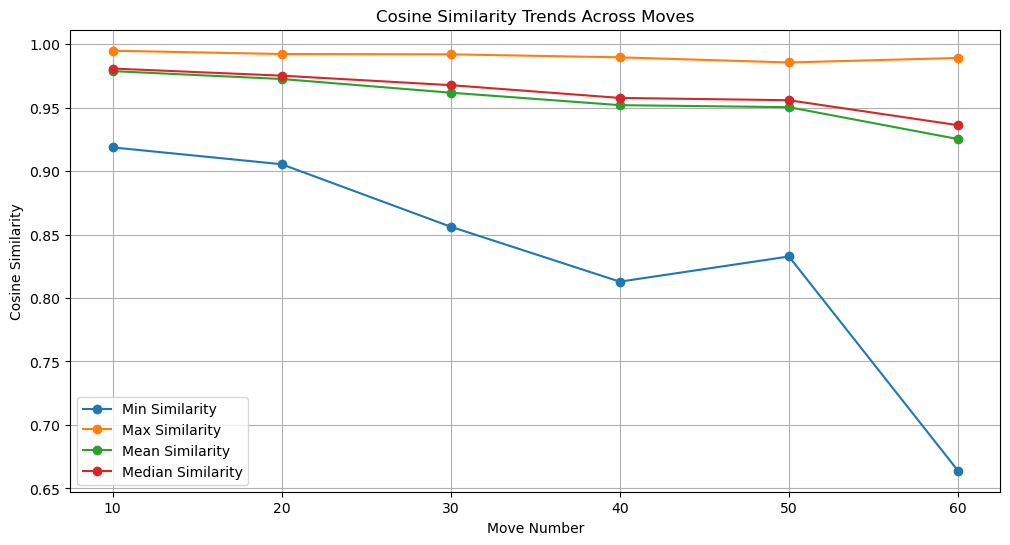

In [109]:
plot_similarity_trends(result)

The result of at least this limited experiment does not land support to my hypothesis. According to ResNet50 the range of similarity of board states increases as the games progress from move 10 to move 60. The mean and median similarity, however, did not increase much, suggesting that some outlier board states are widening the range. Still, I think this was an interesting experiment and I believe it can be improved in a number of ways:
*   Larger sample size - looking at many more games would give greater weight to the results no matter if they support our hypothesis or not.
*   Looking at more gradual changes in similarity - taking "snapshots" of the board position at every move would show the overall tendencies better if they exist at all.
*   Looking at even longer games - in games longer than 60 moves there is more opportunity for the processes I described as potential cause of board states becoming more similar again to happen. This point, however, could be in conflict with the first point - it could be hard to find very many very long games and even if we do if they are a small percentage of all chess games the results would not matter much in the big picture.
*   Trying different ways to encode the chess board state as an image and potentially different color combinations.
*   Using a model specifically trained for the task instead of a pretrained model like ResNet50. Overall, ResNet50 does not seem very sensitive to changes in chess board states images, all images are quite similar to it. A custom model could be more sensitive to changes in the input.

### Findings
* Is the player playing with the white pieces or the player playing with the black pieces favored to win, or is a draw the most likely outcome of the game?<br>
White enjoys an advantage in all the datasets and this advantage grows quite large as skill level increases. The percentage of drawn games increases greatly with a stronger player pool.
* How common are upsets in chess? Are upsets with a higher gap in rating between the opponents correspondingly rarer?<br>
In engine chess upsets are much less common overall. In the dataset where there is specific tournament pairing dynamic (ChessCom) smaller upsets are less likely to happen, because of many  "mismatches" and less opportunity of small upsets.
* What are the "hot" and "cold" spots on the chess board for different pieces(squares on which the piece is placed often or rarely)?
Results can be seen in the heatmaps.
* Is it important to control and fight for the center of the board in a chess game.<br> 
Controlling the center might be a small contributing factor to the outcome of the game.
* How does the similarity between board states in different games evolve through the course of a long game?<br>
In a limited experiment with a tiny sample size the similarity continues to decrease over the course of the game at least up to move 60.

### Acknowledgements:

*   This presentation was prepared as a final project for the course **Data Science** organized by **SoftUni** and taught by **Yordan Darakchiev**. This a  [link](https://softuni.bg/) to the website for SoftUni.
*   The raw data used for the lichess_data dataset was made available by the **lichess.org team** and can be found at: [link](https://database.lichess.org/).  A part of the games from the month of May, 2024 were used.
*   The raw data used for the chessom_data dataset was collected and organized by **Chess Nerd**. The data can be found at the following [link](https://chessnerd.net/pgn/chesscom/titled-tuesday/). All the games from Titled Tuesday 2024 were used.
*   The raw data for the engine_games was made available by the **TCEC team** and can be seen here [link](https://github.com/TCEC-Chess/tcecgames/releases)